# Convergence Rate for Pure, First-Order Feedback on SO(2) and SO(3)

This is an attempt for simple, empirical / numeric checks for expected convergence rates against:
- feedback and integration as ODE for scalar Euclidean space $\mathbb{R}^1$ \
  (if I can't do this, then ain't no worth moving forward here)
- feedback via $\dot{\theta}$ and integration as ODE on $SO(2)$
- feedback via $\omega$ and integration as ODE on $SO(3)$

## Helper Stuff

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import (
    AngleAxis,
    DiagramBuilder,
    Integrator,
    LeafSystem,
    RotationMatrix,
    Simulator,
)

In [2]:
class SimpleVector(LeafSystem):
    def __init__(self, num_q, calc_qd):
        super().__init__()

        self.q = self.DeclareVectorInputPort("q", num_q)

        def calc_qd_sys(context, output):
            q = self.q.Eval(context)
            qd = calc_qd(q)
            output.set_value(qd)

        self.qd = self.DeclareVectorOutputPort("qd", num_q, calc_qd_sys)


def integrate(q0, calc_qd, tf, *, accuracy=1e-5):
    num_q = len(q0)

    builder = DiagramBuilder()
    integ = builder.AddSystem(Integrator(num_q))
    q_actual_port = integ.get_output_port()
    controller = builder.AddSystem(SimpleVector(num_q, calc_qd))
    builder.Connect(q_actual_port, controller.q)
    builder.Connect(controller.qd, integ.get_input_port())

    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    integ_context = integ.GetMyContextFromRoot(diagram_context)
    controller_context = controller.GetMyContextFromRoot(diagram_context)

    integ.set_integral_value(integ_context, q0)

    ts = []
    q_as = []

    def monitor(diagram_context_in):
        assert diagram_context_in is diagram_context
        t = diagram_context.get_time()
        q_actual = q_actual_port.Eval(integ_context)
        ts.append(t)
        q_as.append(q_actual)

    simulator = Simulator(diagram, diagram_context)
    simulator.set_monitor(monitor)
    integrator = simulator.get_mutable_integrator()
    integrator.set_target_accuracy(accuracy)
    try:
        simulator.AdvanceTo(tf)
    except Exception:
        t = diagram_context.get_time()
        print(f"Error at t={t}")
        raise
    return ts, q_as

In [3]:
def maxabs(x):
    return np.max(np.abs(x))

def flatten(R):
    return R.flat[:]

def unflatten(q):
    n = int(np.sqrt(len(q)))
    assert len(q) == n * n
    return q.reshape((n, n))

def normalize(x, *, tol=1e-10):
    x = np.asarray(x)
    n = np.linalg.norm(x)
    assert n >= tol
    return x / n

def rot2d(th):
    s = np.sin(th)
    c = np.cos(th)
    return np.array([
        [c, -s],
        [s, c],
    ])

def rot2d_jac(th):
    s = np.sin(th)
    c = np.cos(th)
    return np.array([
        [-s, -c],
        [c, -s],
    ])

def so2_angle(R):
    x = R[0, 0]
    y = R[1, 0]
    return np.arctan2(y, x)

def so2_dist(R_a, R_d):
    return so2_angle(R_a.T @ R_d)

def unskew(R, *, tol=1e-10):
    if tol is not None:
        dR = R + R.T
        assert np.all(np.max(np.abs(dR)) < tol)
    r1 = R[2, 1]
    r2 = R[0, 2]
    r3 = R[1, 0]
    return np.array([r1, r2, r3])

def axang(ax, th):
    """Exponential-map thinger."""
    # return RotationMatrix(AngleAxis(angle, axis)).matrix()
    S = skew(ax)
    R = np.eye(3) + S * np.sin(th) + S @ S * (1 - np.cos(th))
    return R

def so3_angle(R):
    # same as AngleAxis(R).angle()
    th = np.arccos((np.trace(R) - 1) / 2)
    return th

def to_axang(R, *, tol=1e-10):
    # axang = AngleAxis(R)
    # ax, th = axang.axis(), axang.angle()
    th = so3_angle(R)
    if np.abs(th) < tol:
        ax = np.array([0, 0, 1])
    else:
        s = np.sin(th)
        ax = 1 / (2 * s) * np.array([
            R[2, 1] - R[1, 2],
            R[0, 2] - R[2, 0],
            R[1, 0] - R[0, 1],
        ])
    return ax, th

def to_axang3(R, *, tol=1e-10):
    """Log-map thinger."""
    ax, th = to_axang(R, tol=tol)
    return ax * th

def so3_dist(R_a, R_b):
    return so3_angle(R_a.T @ R_b)

def skew(r):
    r1, r2, r3 = r
    return np.array(
        [
            [0, -r3, r2],
            [r3, 0, -r1],
            [-r2, r1, 0],
        ]
    )

## Sanity $\mathbb{R}^1$ Check

Dirt simple, coordinate $x$, with $x_0 \ne 0$, controller and solution should be

\begin{align}
    \dot{x} &= -x \\
    x(t) &= x_0 e^{-t}
\end{align}

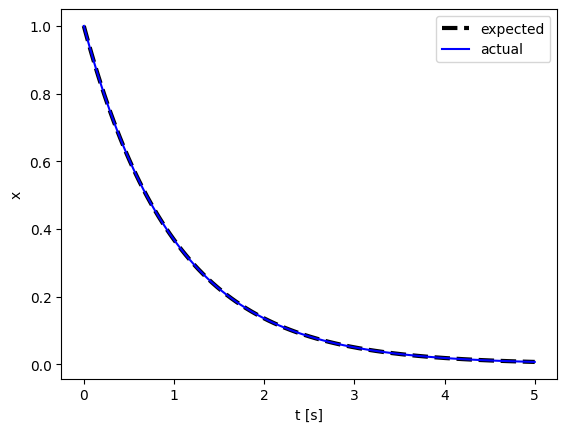

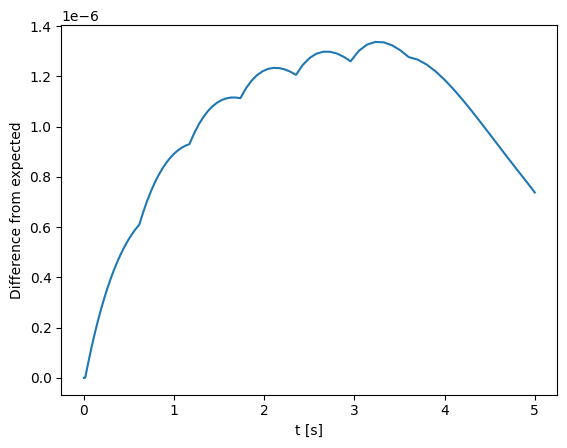

In [4]:
x0 = 1.0
q0 = [x0]

def calc_x_expected(t):
    x = x0 * np.exp(-t)
    return x

def q_to_x(q):
    x, = q
    return x

def calc_qd(q):
    x = q_to_x(q)
    x_err = x
    xd = -x_err 
    qd = [xd]
    return qd

ts, q_as = integrate(q0=q0, calc_qd=calc_qd, tf=5.0)
x_as = [q_to_x(q_a) for q_a in q_as]
x_es = [calc_x_expected(t) for t in ts]
ts, x_as, x_es = map(np.asarray, (ts, x_as, x_es))

plt.figure()
plt.plot(ts, x_es, "k--", linewidth=3, label="expected")
plt.plot(ts, x_as, "b-", label="actual")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.legend()

plt.figure()
plt.plot(ts, np.abs(x_as - x_es))
plt.xlabel("t [s]")
plt.ylabel("Difference from expected")
pass

## SO(2)

General rotation:
\begin{align}
    c &= cos(\theta) \\
    s &= sin(\theta) \\
    R(\theta) &=
        \begin{bmatrix}
            c & -s \\
            s & c
        \end{bmatrix} \\
    \dot{R}(\theta, \dot{\theta}) &=
        \begin{bmatrix}
            -s & -c \\
            c & -s
        \end{bmatrix} \dot{\theta}
\end{align}

Define simple first-order feedback with expected closed-form solution:
\begin{align}
    \dot{\theta} &= -\theta \\
    \theta(t) &= \theta_0 e^{-t}
\end{align}

But for kicks and giggles, integrate against $SO(2)$ via coordinate change as
\begin{align}
    R(t) = \int_0^t \dot{R}\left(\theta, \dot{\theta}\right) \ dt
\end{align}

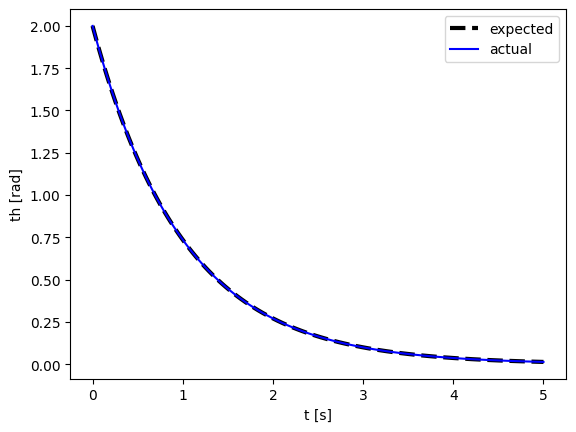

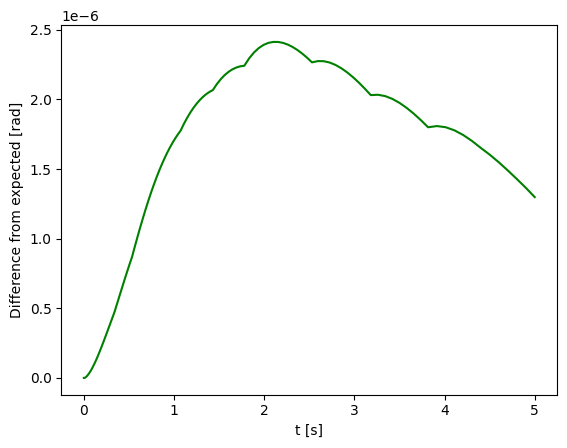

In [5]:
theta0 = 2.0
R0 = rot2d(theta0)
q0 = flatten(R0)

def calc_th_expected(t):
    theta = theta0 * np.exp(-t)
    return theta

def q_to_th(q):
    R = unflatten(q)
    so2_tol = 1e-5
    so2_err = R @ R.T - np.eye(2)
    assert maxabs(so2_err) < so2_tol, so2_err
    return so2_angle(R)

def calc_qd(q):
    R = unflatten(q)
    th = so2_angle(R)
    th_err = th
    thd = -th_err
    Rd = rot2d_jac(th) * thd
    qd = flatten(Rd)
    return qd

ts, q_as = integrate(q0=q0, calc_qd=calc_qd, tf=5.0)
th_as = [q_to_th(q_a) for q_a in q_as]
th_es = [calc_th_expected(t) for t in ts]
ts, th_as, th_es = map(np.asarray, (ts, th_as, th_es))

plt.figure()
plt.plot(ts, th_es, "k--", linewidth=3, label="expected")
plt.plot(ts, th_as, "b-", label="actual")
plt.xlabel("t [s]")
plt.ylabel("th [rad]")
plt.legend()

plt.figure()
plt.plot(ts, np.abs(th_as - th_es), "g")
plt.xlabel("t [s]")
plt.ylabel("Difference from expected [rad]")
pass

## SO(3)

### References

[MLS] Murray, Richard M., Zexiang Li, and S. Shankar Sastry. \
&nbsp;&nbsp; A Mathematical Introduction to Robotic Manipulation. 1st ed. CRC Press, 2017. \
&nbsp;&nbsp; https://doi.org/10.1201/9781315136370. \
&nbsp;&nbsp; <http://www.cds.caltech.edu/~murray/books/MLS/pdf/mls94-complete.pdf>

[MITI] Mitiguy, Paul. \
&nbsp;&nbsp; Advanced Dynamics & Motion Simulation: For Professional Engineers and Scientists (Graduate Work); 3D, Computational, Guided. \
&nbsp;&nbsp; Prodigy Press, 2021. \
&nbsp;&nbsp; <http://www.motiongenesis.com/MGWebSite/MGTextbooks/TextbookAdvancedDynamicsAndMotionSimulation.html>

[LLM] Lee, Taeyoung, Melvin Leok, and N. Harris McClamroch. \
&nbsp;&nbsp; “Control of Complex Maneuvers for a Quadrotor UAV Using Geometric Methods on SE(3).” arXiv, March 9, 2010. \
&nbsp;&nbsp; https://doi.org/10.48550/arXiv.1003.2005.

[ASW] Akhtar, Adeel, Sajid Saleem, and Steven L. Waslander. \
&nbsp;&nbsp; “Feedback Linearizing Controllers on SO(3) Using a Global Parametrization.” \
&nbsp;&nbsp; In 2020 American Control Conference (ACC), 1441–46, 2020. \
&nbsp;&nbsp; https://doi.org/10.23919/ACC45564.2020.9147963.

[A] Akhtar, Adeel. \
&nbsp;&nbsp; “Nonlinear and Geometric Controllers for Rigid Body Vehicles.” Doctoral Thesis, \
&nbsp;&nbsp; University of Waterloo, 2018. \
&nbsp;&nbsp; https://uwspace.uwaterloo.ca/handle/10012/14006.

[SDA] Solà, Joan, Jeremie Deray, and Dinesh Atchuthan. \
&nbsp;&nbsp; “A Micro Lie Theory for State Estimation in Robotics.” \
&nbsp;&nbsp; arXiv, December 8, 2021. https://doi.org/10.48550/arXiv.1812.01537.

#### Discussion stuff

[MLS] lota stuff, incl. nice compact section on SO(3) and exponential coordinates.

[MITI] lotsa stuff, incl. info on rotation representations, angular velocities, accelerations, and the frames in which you gotta consider em.

[LLM] has some convergence *bounds* regarding convergence of (second-order) feedback linearization on $SE(3)$, but it'd
be nice to vet this stuff. It's feedback control law is tested below in contrast to log-space stuff.

[ASW] does feedback linearization on SO(3) and provides explicit connection to log map in Eq. (10), and connects that
to time derivative of log map in [A], Eq. (6.8).

Found [SDA] via survey paper stuff (http://arxiv.org/abs/1711.03896), it's got some purty nice stuff on Lie manifolds.
However, didn't (quickly) see direct connection on time derivative of log map for use as feedback signal, but it did
go into details on finite difference on manifolds / tangent spaces and (I think) differential flatness.

### General Setup

Per [LLM] and other peeps with that notation, let:

- $\hat{}: \mathbb{R}^3 \rightarrow so(3)$ produce skew matrices
- $^\vee: so(3) \rightarrow \mathbb{R}^3$ be its inverse

First, restate the standard relationship between $R \in \mathbb{R}^{3 \times 3}$, its time derivatives,
and angular velocities (*world frame* or *body frame*):

\begin{align}
    & \text{(world frame)} \\
    \dot{R} &= {}^W\hat{\omega} R \\
    {}^W\hat{\omega} &= \dot{R} R^T \\
    \\
    & \text{(body frame)} \\
    \dot{R} &= R \ \ {}^B\hat{\omega} \\
    {}^B\hat{\omega} &= R^T \dot{R} \\
\end{align}

Per [MLS], define exponential map as $R(\lambda, \theta)$ as in Eq. (2.14), where
$\lambda \in \mathbb{R}^3, |\lambda| = 1$,
$\theta \in \mathbb{R}$. \
Define log map as $\log(R)$ to recover exponential coordinates $\lambda \theta$ per Eq. (2.17), (2.18). \
Can use `AngleAxis` from Eigen, bound in Python via `pydrake`.

For control, we want to drive our actual orientation, $R_a(t)$, towards our desired orientation, $R_d(t)$. \
Using Kane's notation, assuming we're trying to drive frame B w.r.t. inertial world frame W, we can denote stuff more verbosely as
- $R_a = {}^{W}R^{B_a}$ (frame B's actual orientation w.r.t. world frmae W)
- $R_d = {}^{W}R^{B_d}$ (frame B's desired orientation w.r..t world frame W)

But for compactness, just using $R_a, R_d$.

Let $R_{a,0} = R(\lambda, \theta_0)$, for (what is hopefully a) constant $\lambda$ across this solution. \
Let $R_d = I$ for simplicity (similar to above cases of converging to origin / identity).

**Note**: Because the solution *should be* along a single axis, meaning feedback should only act along that axis,
and this axis is a eigenvector of the rotation matrix, then changing between world frame and body frame
*for this setup* shouldn't really matter 😬

Using this, we define the following first-order feedback and dynamics, with the expected solution:

\begin{align}
    & \text{(world frame)} \\
    ^{W}\omega &= -e_R \\
    \dot{R} &= {}^W\hat{\omega} R \\
    \\
    & \text{(body frame)} \\
    ^{B}\omega &= -e_R \\
    \dot{R} &= R \ \ {}^B\hat{\omega} \\
    \\
    & \text{Expected Solution} \\
    \theta(t) &= \theta_0 e^{-t} \\
    R(t) &= R(\lambda, \theta(t))
\end{align}

For plotting, we use the angle between rotations, $d(R_1, R_2) = |\log(R_1^T R_2)|$.

For feedback, we try out two (among *many*) options for feedback:

- Use log-space (`err_mode="log"`)
- Use [LLM]'s time-derivative of the trace (`err_mode="paper"`)

### Rotation Differencing

The two setups below rely on differnce in rotations; here're the two options (I think),
where $R_\Delta$ provides the diff, and $R_\omega$ reorients the error into the desired frame

\begin{align}
    & \text{(world frame - extrinsic)} \\
    R_\Delta &= R_a R_d^T \\
    R_\omega &= I \\
    \\
    & \text{(body frame - intrinsic)} \\
    R_\Delta &= R_d^T R_a \\
    R_\omega &= R_a^T R_d = R_\Delta^T \\
\end{align}

### Log-space

\begin{align}
    e_R &= R_\omega \log(R_\Delta)
\end{align}

from what seems like 

### Paper's Formulation

Use formulation as shown in [LLM], Eq. (10):

\begin{align}
    e_R &= \frac{1}{2} R_\omega \left( R_\Delta - R_\Delta ^T \right)^\vee
\end{align}

**TODO**(eric.cousineau): Er, the paper's convergence properties seem very sub-exponential. \
Should check to see if I messed something up, or these are their expected bounds.

$\theta_0$ = 1, err_mode=log
  max_diff = 0.000665


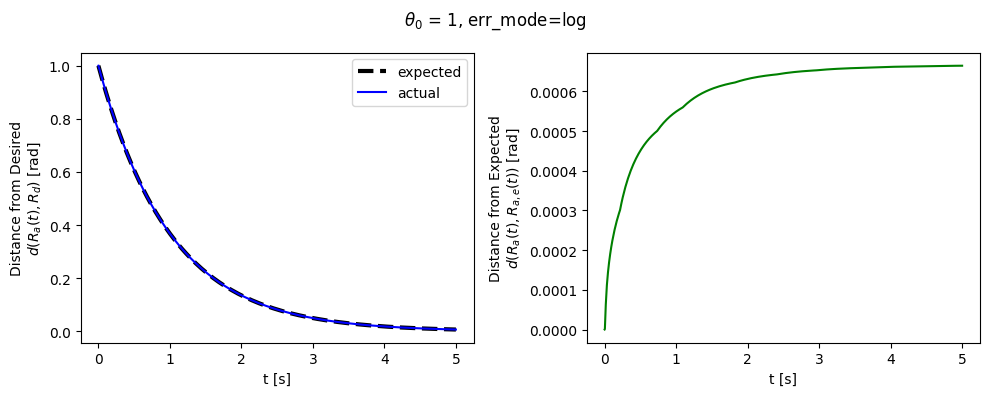

$\theta_0$ = 1, err_mode=paper
  max_diff = 0.0338


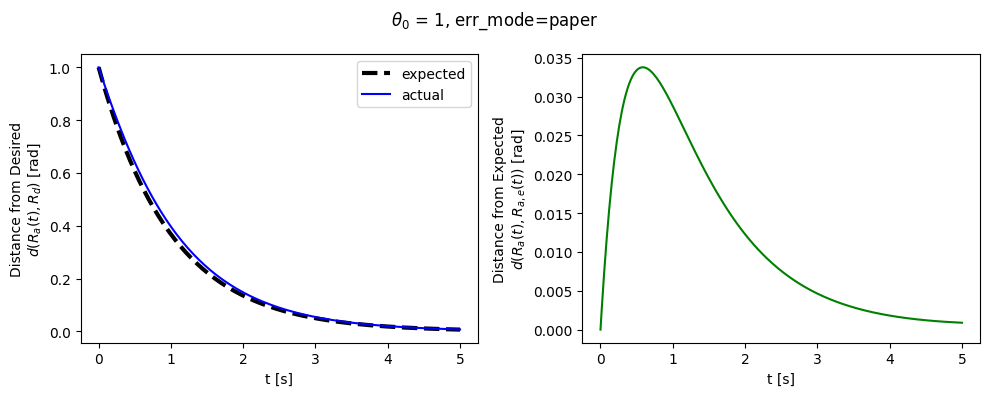

$\theta_0$ = 3.14, err_mode=log
  max_diff = 0.000946


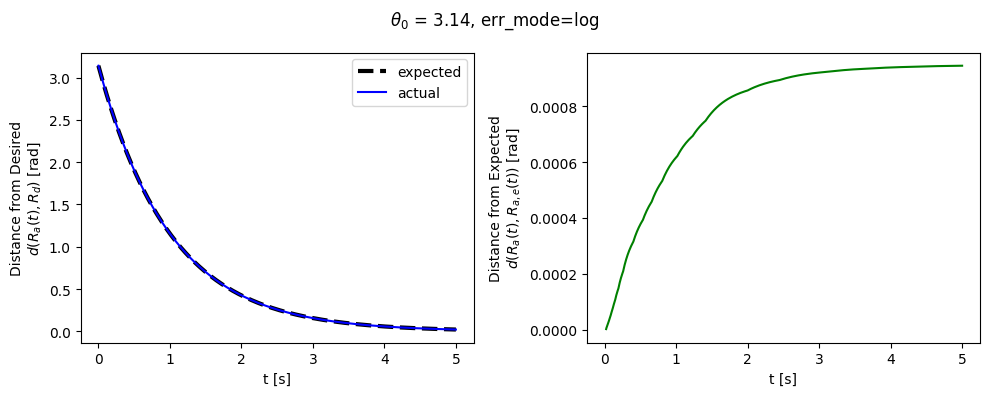

$\theta_0$ = 3.14, err_mode=paper
  max_diff = 3.03


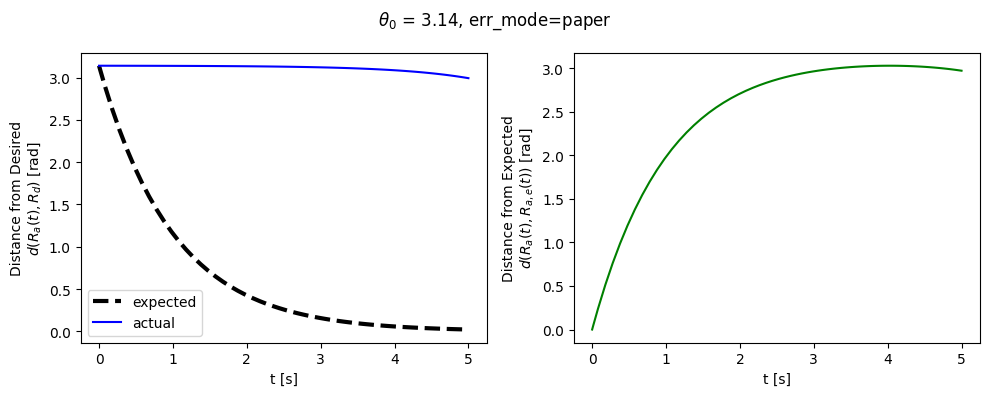

In [6]:
def check_so3(theta0, *, err_mode, use_world_frame, do_plot):
    axis = normalize([0.2, 0.3, 0.4])
    R0 = axang(axis, theta0)
    q0 = flatten(R0)

    R_d = np.eye(3)

    def calc_R_expected(t):
        assert (R_d == np.eye(3)).all()
        theta = theta0 * np.exp(-t)
        R = axang(axis, theta)
        return R

    def q_to_R(q, *, check=True):
        R = unflatten(q)
        if check:
            so3_tol = 1e-4
            so3_err = R @ R.T - np.eye(3)
            assert maxabs(so3_err) < so3_tol, so3_err
        return R

    def rot_error_paper(R_a, R_d):
        if use_world_frame:
            # Modify for world frame feedback.
            dR = R_a @ R_d.T
        else:
            dR = R_d.T @ R_a
        err_hat = (dR - dR.T) / 2
        return err_hat

    def rot_error_log(R_a, R_d):
        R = R_a @ R_d.T
        w = to_axang3(R)
        if use_world_frame:
            pass
        else:
            w = R_a.T @ w
        return skew(w)

    def calc_qd(q):
        R_a = q_to_R(q, check=False)
        if err_mode == "paper":
            err_hat = rot_error_paper(R_a, R_d)
        elif err_mode == "log":
            err_hat = rot_error_log(R_a, R_d)
        else:
            assert False
        w_hat = -err_hat
        if use_world_frame:
            Rd_a = w_hat @ R_a
        else:
            Rd_a = R_a @ w_hat
        qd = flatten(Rd_a)
        return qd

    ts, q_as = integrate(q0=q0, calc_qd=calc_qd, tf=5.0, accuracy=1e-6)
    R_as = [q_to_R(q_a) for q_a in q_as]
    R_es = [calc_R_expected(t) for t in ts]
    diffs = [so3_dist(R_a, R_e) for (R_a, R_e) in zip(R_as, R_es)]
    th_as = [so3_dist(R, R_d) for R in R_as]
    th_es = [so3_dist(R, R_d) for R in R_es]

    ts, diffs, th_as, th_es = map(np.asarray, (ts, diffs, th_as, th_es))

    # TODO(eric): Should fix this.
    good = np.isfinite(diffs)
    max_diff = maxabs(diffs[good])

    if do_plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
        plt.sca(axs[0])
        plt.plot(ts, th_es, "k--", linewidth=3, label="expected")
        plt.plot(ts, th_as, "b-", label="actual")
        plt.xlabel("t [s]")
        plt.ylabel("Distance from Desired\n$d(R_a(t), R_d)$ [rad]")
        plt.legend()

        plt.sca(axs[1])
        plt.plot(ts, diffs, "g")
        plt.xlabel("t [s]")
        plt.ylabel("Distance from Expected\n$d(R_a(t), R_{a,e}(t))$ [rad]")
    return max_diff

for theta0 in [1.0, np.pi - 0.001]:
    for err_mode in ["log", "paper"]:
        for use_world_frame in [True]: #, False]:
            title = f"$\\theta_0$ = {theta0:.3g}, err_mode={err_mode}" #, use_world_frame={use_world_frame}"
            print(title)
            do_plot = use_world_frame
            max_diff = check_so3(
                theta0, err_mode=err_mode, use_world_frame=use_world_frame, do_plot=do_plot
            )
            plt.suptitle(title)
            plt.tight_layout()
            print(f"  max_diff = {max_diff:.3g}")
            plt.show()